In [14]:
import numpy as np
from MDAnalysis.lib import distances
from collections import defaultdict
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from tqdm import tqdm_notebook
import itertools
import cellgrid

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

This notebook includes benchmarks of distance calculations for different data structures  particularly brute force, cell-list and KDtree. More specifcally, it lists the time for building the data structure and accessing single point query time for each structure. Respective comparison with expected theoretical runtimes are also included.    

Different sources are used to access the mentioned data structues. Cellgrid package utilizes the cell-list data structure but with grid size equivalent to the cutoff distance search. Another wrapper around Cellgrid is proposed, which have independent cellsize and cutoff-distance as its parameter. Periodic KDTree data structure is already implemented in MDAnalysis, which is most often used for pair searches and near neighbour selection. Brute force method is also implemented in MDAnalysis under distances module.  

The notebook is arranged in the following way:
* Class and function definition for Cell List.
* Methods for build and query time for each data structure
* Tests
* Variation of build Time with increase in number of points (i.e. increasing density)
* Variation of query time with number of points
* Two cases with different number of particles to check the variation of grid size used in cell list for constant cutoff radius.

This is one of the elementary operation for neighbour search, and therefore selected for benchmarking distance calculations. 

# Initialization Data

In [3]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

def _check_box(box):
        return box[:3] if box.shape == (6,) else box    

Assuming uniform distribution. The actual distribution will affect the results and time. 

# Data Structure

A data structure of [Cell-List](https://gist.github.com/kain88-de/5002b18630e89c8ce839c2841ebe441d) is utilized here for single point query. Another package [Cellgrid](https://github.com/MDAnalysis/cellgrid/blob/master/cellgrid) also uses CellList data structure, but is not an optimized version for single point query and will be demonstrated further in the notebook.

In [6]:
class CellList(object):
    """Generate cell list object

    The cell list is stored as a sparse hash-map. Hashes are the 3d coordinates.
    The goal for this implementation is to quickly find neighbors to a single point.
    Using the dict ensures that we only create 'cells' that are actually occupied.
    """
    nei = [-1, 0, 1]
    NEIGHBORS = list(itertools.product(nei, nei, nei))

    def __init__(self, box, coords, cell_size):
        self._box = _check_box(box)
        # pack coords into box
        self._coords = distances.apply_PBC(coords.astype(np.float32), self._box.astype(np.float32))
        self._cell_size = np.ones(3) * cell_size

        self._ncells = (self._box // self._cell_size).astype(int) + 1

        cells = (self._coords // self._cell_size).astype(int)
        cell_map = defaultdict(list)
        for i, cell in enumerate(cells):
            cell_map[tuple(cell)].append(i)
        self._cell_map = cell_map
        
    

    def candidates(self, pos):
        """return all candidate coordinates for pos

        This means all coordinates of the cell in which pos is and all it's
        neighboring cells.

        """
        cell = (pos // self._cell_size).astype(int)
        indices = []
        for neighbor_shift in self.NEIGHBORS:
            neighbor_cell = self._apply_PBC(cell, neighbor_shift)
            indices.extend(self._cell_map[tuple(neighbor_cell)])

        return self._coords[indices]
    
    def search(self, pos, cutoff):
        pos = np.array(pos, dtype=np.float32)
        cand = self.candidates(pos)
        dist = distances.distance_array(pos[np.newaxis, :], cand, box=self._box)[0]
        return cand[dist <= cutoff]
    
    def _apply_PBC(self, cell, shift):
        address = cell + shift
        w = address >= self._ncells
        address[w] -= self._ncells[w]
        w = address < 0
        address[w] += self._ncells[w]
        return address
    
    

Typically, cell-list data structure involves creating a grid of cells followed by asignment of each particle to its respective cell based on its location. This contruction, by itself, has a time complexity of O(N) and space complexity of O(kN) where k depends on the grid spacing of cell. 
A single point query requires brute force distance calculation between the query point and all the coordinates in the neighbouring cells. For this algorithm, the worst performing case is when all the particles are clustered in a single cell which scales as O(N^2), whereas the best performance is achieved for uniform distribution. The time complexity for best performing case is O(kN^2), where k is very small depending on the average number of particles in each cell. Additionally, it needs to check 27 cells around the parent cell, which adds to the time complexity. Space complexity also varies as O(kN^2) where one needs to store interparticle distances between neighbouring cells. Please note that this is not a rigourous analysis, but an estimate to understand the variation of execution time and space consumption.

[KDTree](https://github.com/MDAnalysis/mdanalysis/blob/develop/package/MDAnalysis/lib/pkdtree.py) constructs a tree data structure using positions of particles. Periodic boundary condition are used such that all the points are centred around the central cell and the data structure is constructed around the central cell. Only the relevant periodic images are queried for the nearest neighbour search. This construct increase the query time as compared to non periodic KDtree, but searching relevant images only slows down the search by a small factor. Variation of query time due to periodicity can be seen [here](https://www.google.com/url?q=https%3A%2F%2Fgithub.com%2FMDAnalysis%2Fmdanalysis%2Fpull%2F1692&sa=D&sntz=1&usg=AFQjCNHKtA6_kwS7LlKWDE42of7MOY8a5w) 

In [7]:
def kdtree_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def kdtree_query(struct, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

Ideally construction of KDtree requires finding the median of the points and seperating the points based on the median. Since we use constant number of bins (i.e. 10 mostly), the majority of time during construction depends on evaluating the median and binning the particles, which scales linearly with number of particles. Therefore, the time complexity varies as O(N). The space complexity due to construction of trees is constant due to constant number of leaf nodes, but depends only on storing each particle in its respective leaf node which depends on the distribution of particles (O(N) for uniform distribution).

Query time require depth search to find the first closest leaf node and traverse all the nearest leaf nodes (using temporary queues). For a high dimensional tree structure, most of the time is consumed in traversing the tree, whereas in our case, due to fixed number of leafnodes, time to traverse a tree is almost constant i.e. O(nlogn) where n is the number of leaf nodes. Once neighbouring leaf nodes are assessed based on the cutoff distance, all the distances between query point and points inside the leaf node are evaluated. Therefore the query time depends on the number of particles present inside every leafnode and number of neighbouring leafnodes around a query point. The time complexity for querying in kdtree, therefore, varies as O((N/k)^2nlogn) where k depends on the distribution of particles in each leaf. 

Cell List implementation in Cellgrid should also be checked for single point query. It progresses by constructing two equivalent cellgrids with different group of particles in each object and finding distances between all the combinations within the neighbouring cell. While this is not the best way, and similar treatment as done in Cell-list can be carried out which will result in similar query time. For a multiple query or a pair contact analysis, this approach is available in cellgrid and could be useful in those cases. 

In [8]:
def cellgrid_build(box, coords, cellsize):
    cg1 = cellgrid.CellGrid(_check_box(box), cellsize, coords)
    return cg1
def cellgrid_query(struct,pos,cutoff):
    cg2 = cellgrid.CellGrid(struct._box,struct._cell_size, pos[np.newaxis, :])
    indices, dist = cellgrid.cellgrid_distance_array(cg2, struct)
    return struct.coordinates[indices[dist < cutoff][:,1]]

# Testing

In [9]:
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 10.
NPOINTS = 1000
coords = get_coords(BOX, NPOINTS)

In [10]:
#Point to test
pos = coords[1]

In [11]:
#KDTree
pkdt = kdtree_build(BOX, coords)
kd_neighbor = kdtree_query(pkdt, pos, CUTOFF)
kd_neighbor

array([[76.17692 , 60.179283, 80.95493 ],
       [81.084564, 53.61373 , 81.786514],
       [74.18051 , 63.95156 , 78.099106],
       [84.11168 , 58.346905, 76.32582 ],
       [78.90214 , 61.166874, 72.569046],
       [80.094734, 51.704967, 78.54351 ],
       [78.08158 , 61.199097, 72.23159 ],
       [75.11839 , 55.85796 , 84.72054 ]], dtype=float32)

In [15]:
# Cell List
cl = CellList(BOX, coords, CUTOFF)
cl_neighbor = cl.search(pos, CUTOFF)
print(cl_neighbor)

[[75.11839  55.85796  84.72054 ]
 [74.18051  63.95156  78.099106]
 [78.90214  61.166874 72.569046]
 [78.08158  61.199097 72.23159 ]
 [76.17692  60.179283 80.95493 ]
 [84.11168  58.346905 76.32582 ]
 [80.094734 51.704967 78.54351 ]
 [81.084564 53.61373  81.786514]]


In [16]:
# Cellgrid
cg = cellgrid_build(BOX, coords, CUTOFF)
cg_neighbor = cellgrid_query(cg, pos, CUTOFF)
print(cg_neighbor)

[[76.17692  60.179283 80.95493 ]
 [75.11839  55.85796  84.72054 ]
 [81.084564 53.61373  81.786514]
 [80.094734 51.704967 78.54351 ]
 [84.11168  58.346905 76.32582 ]
 [78.90214  61.166874 72.569046]
 [74.18051  63.95156  78.099106]
 [78.08158  61.199097 72.23159 ]]


In [17]:
for a, b in itertools.combinations([kd_neighbor, cl_neighbor, cg_neighbor], 2):
    np.testing.assert_equal(np.sort(a,axis=0),np.sort(b,axis=0))

# Timings

Comparison of build timings for data structure with increase in number of particles in a bounding box of constant volume.

In [18]:
# Using constant cutoff distance
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
pos = BOX[:3] / 2.

In [19]:
res = defaultdict(list)
res_build = defaultdict(list)

for N in tqdm_notebook(np.unique(np.logspace(2, 5, num=10).astype(int))):
    
    coords = get_coords(BOX, N)

    # Building test 
    res_pkdt = %timeit -o -q kdtree_build(BOX,coords)
    res_cl = %timeit -o -q CellList(BOX, coords, CUTOFF)
    res_cg = %timeit -o -q cellgrid_build(BOX, coords, CUTOFF)
    
    res_build['pkdt'].append(res_pkdt.average)
    res_build['cl'].append(res_cl.average)
    res_build['cg'].append(res_cg.average)
    res_build['N'].append(N)
    
    # Query
    kdt = kdtree_build(BOX,coords)
    cl = CellList(BOX, coords, CUTOFF)
    cg=cellgrid_build(BOX, coords, CUTOFF)
    res_pkdt = %timeit -o -q kdtree_query(kdt, pos, CUTOFF)
    res_cl = %timeit -o -q cl.search(pos, CUTOFF)
    res_cg = %timeit -o -q cellgrid_query(cg, pos, CUTOFF)
        
    res['pkdt'].append(res_pkdt.average)
    res['cl'].append(res_cl.average)
    res['cg'].append(res_cg.average)
    res['N'].append(N)

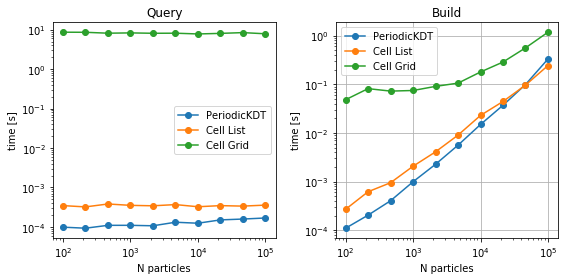

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2))

ax = axes[0]
ax.plot(res['N'], res['pkdt'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res['cl'], 'o-', label='Cell List')
ax.plot(res['N'], res['cg'], 'o-', label='Cell Grid')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.legend()

ax = axes[1]
ax.plot(res['N'], res_build['pkdt'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res_build['cl'], 'o-', label='Cell List')
ax.plot(res['N'], res_build['cg'], 'o-', label='Cell Grid')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.grid(True)
ax.legend()

fig.tight_layout()

Since it is established, the method celllist is better than Cellgrid package (both use cell-list data structure), both in terms of building the structure as well as for a single query. The next module demonstrates the variation of different cellsize for cutoff distance. This is to exploit the time difference between building and querying the data structure. First we shall see the variation in time for building the data structure for different cellsizes and if it can be optimized for celllist data structures.

In [21]:
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
pos = BOX[:3] / 2.
Npoints = [20000,40000]
coords = [get_coords(BOX, np) for np in Npoints]

In [22]:
res = defaultdict(list)
res_build = defaultdict(list)
for cs in tqdm_notebook(np.unique(np.linspace(4, 20, num=9).astype(float))):
    for num in range(len(Npoints)):
        #Build Time
        res_cl = %timeit -o -q CellList(BOX, coords[num], cs)
        res_build['cl'+str(num)].append(res_cl.average)
        #Query
        cl=CellList(BOX, coords[num], cs)
        res_cl = %timeit -o -q cl.search(pos,CUTOFF)
        res['cl'+str(num)].append(res_cl.average)
        res['cs'+str(num)].append(cs)

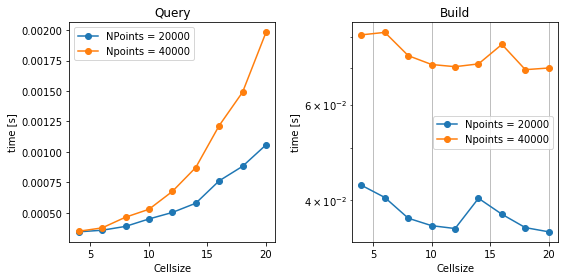

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2))

ax = axes[0]
ax.plot(res['cs0'], res['cl0'], 'o-', label='NPoints = {}'.format(Npoints[0]))
ax.plot(res['cs1'], res['cl1'], 'o-', label='Npoints = {}'.format(Npoints[1]))
ax.set(xlabel='Cellsize', ylabel='time [s]', title='Query')
ax.legend()

ax = axes[1]
ax.plot(res['cs0'], res_build['cl0'], 'o-', label='Npoints = {}'.format(Npoints[0]))
ax.plot(res['cs1'], res_build['cl1'], 'o-', label='Npoints = {}'.format(Npoints[1]))
ax.set(xlabel='Cellsize', ylabel='time [s]', yscale='log', title='Build')
ax.grid(True)
ax.legend()

fig.tight_layout()

For a single point query, it is observed that the majority of the time is spent in building the data structure. For large number of particles, the cell list algorithm works better in comparison to KDtree data structure (MDAnalysis) and cell-list data structure as implemented in CellGrid package.
Few observations can be listed as follows:

1) Majority of time is spent in bulding the data structure, while the time spent is querying the neighbor selection is dependent on the position of the query point. However, one trend is certain for cell-list data structures, building time can be decreased by increasing the cellsize. It should be advisable to use a cellgrid size of 0.1boxsize as opposed to grid size equivalent to the cutoff radius. However, it should be mentioned that smaller grid size than the cutoff distance would produce incorrect results.

2) KDTree is best alternative data-structure for low particle density, but at higher particle density cell-list starts to approach the build time of Cellgrid. Based on the above observation, the total time should further decrease if optimized cell size is used.


Lets check the total time for single point query using optimized grid size for cell-list against KDtree.

In [24]:
# Using constant cutoff distance
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
pos = BOX[:3] / 2.

In [25]:
res = defaultdict(list)
res_build = defaultdict(list)

for N in tqdm_notebook(np.unique(np.logspace(2, 5, num=10).astype(int))):
    
    coords = get_coords(BOX, N)

    # Building test 
    res_pkdt = %timeit -o -q kdtree_build(BOX,coords)
    res_cl = %timeit -o -q CellList(BOX, coords, 0.1*BOX[0])
    
    res_build['pkdt'].append(res_pkdt.average)
    res_build['cl'].append(res_cl.average)
    res_build['N'].append(N)
    
    # Query
    kdt = kdtree_build(BOX,coords)
    cl = CellList(BOX, coords, 0.1*BOX[0])
    res_pkdt = %timeit -o -q kdtree_query(kdt, pos, CUTOFF)
    res_cl = %timeit -o -q cl.search(pos, CUTOFF)
        
    res['pkdt'].append(res_pkdt.average)
    res['cl'].append(res_cl.average)
    res['N'].append(N)

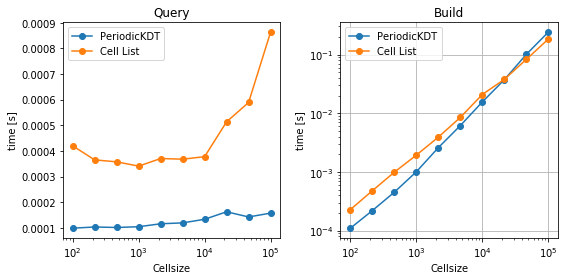

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2))

ax = axes[0]
ax.plot(res['N'], res['pkdt'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res['cl'], 'o-', label='Cell List')
ax.set(xlabel='Cellsize', xscale='log', ylabel='time [s]', title='Query')
ax.legend()

ax = axes[1]
ax.plot(res['N'], res_build['pkdt'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res_build['cl'], 'o-', label='Cell List')
ax.set(xlabel='Cellsize', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.grid(True)
ax.legend()

fig.tight_layout()

# Discussion

For a single point pruning, the time increases by a factor of 9 times at 100k particles while searching for a cutoff of 4 units.  Since build time is still the most time consuming, cellgrid becomes advantageous above 10000 number of particles. This difference, however less, should scale up with the number of prune points i.e when pair contact analysis or neighbour analysis around a group of particles are considered. 
It can be observed that an efficient cell size can be used for reducing the buid time, as query time is reatively small for pruning a single point. However, multiple queries would scale with Query time and kdtree is a better option if nearest neighbours for a group of particles are evaluated by looping over individual pruning.
However, another approach, as implemented in Cellgrid, would be beneficial for multiple pruning, where one can store all the distances between group of particles in a single cell and its neighbouring cells, which would hopefully reduce the amount of selection time drastically.

Another approach also exist, which uses combined cell-list and verlet method for pruning. Basically, the grid spacing is chosen smaller than the cutoff radius. For a given query point, all the cells which are in the neighbourhood (i.e. whose cell motifs are within the radius of cutoff distance) are utilized for distance evaluations. This decreases the amount of cells (27 in our case above) to fewer cells and removes the undesired distance calculations. 
However, the time scales as cube of the number of cells, it would seem that time for single point query could be decreased by use of such algorithm at the cost of high build time. 